# Ensemble Learning
Group Challenge

***
by: Paul Bédier, Lukasz Pszenny, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [93]:
from importlib import reload
reload(prepData)

<module 'util.preprocess_data' from 'c:\\Users\\pbedi\\Documents\\GitHub\\Ensemble-Learning-on-AirBnb-dataset\\util\\preprocess_data.py'>

In [1]:
# import own scripts
import util.preprocess_data as prepData

In [25]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
from PIL import Image
from joblib import dump, load

# modeling tools
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import ConfusionMatrixDisplay, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Retrieve Data

In [4]:
# Retrieve data (including geographical dataframes); can take up to 1min
airbnb, lvl1, lvl2, lvl3, lvl4 = prepData.load_data()

# handle outliers
airbnb = prepData.clip_target(airbnb, method = 'drop')

In [11]:
# perform train test split
airbnb_train, airbnb_test = train_test_split(airbnb, test_size = 0.2, random_state=42)

# validate what happened
print(airbnb.shape)
print(airbnb_train.shape)
print(airbnb_test.shape)

(46907, 61)
(37525, 61)
(9382, 61)


In [12]:
# which columns we want to drop (see notebook 1 on feature selection -- may need to change / review this)
drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
             "lvl4_GeoID", "lvl4_name", "lvl4_HUnits_20",
             "lvl4_HUnits_Ch"] + [i for i in airbnb.columns if "lvl" in i and "lvl4" not in i]

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# create preprocessing pipeline
prep_pipe = prepData.PreprocessingPipeline(lambda_type = "sigmoid", min_listings = 3, k = 15, f = 1.5,
                                           lvl1 = lvl1, lvl2 = lvl2, lvl3 = lvl3, lvl4 = lvl4,
                                           drop_cols = drop_cols)


# fit and transform train & test data
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_test  = prep_pipe.transform(X_test)

# validate
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(37525, 18) (37525,)
(9382, 18) (9382,)


### 3. Evaluate Data

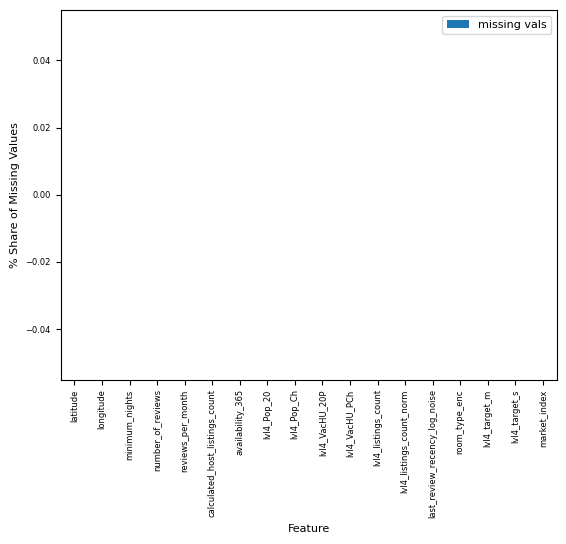

In [7]:
# train data must have no missing values
prepData.show_missing_vals(X_train)

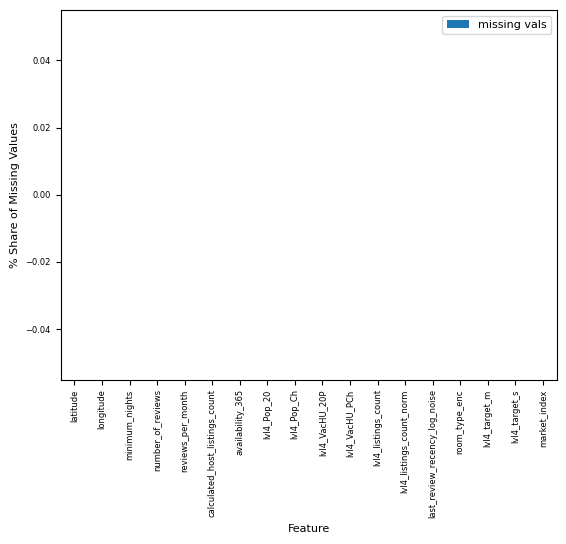

In [8]:
# test data must have no missing values
prepData.show_missing_vals(X_test)

### 4. Model Training

During feature engineering we have created numerous features that are based on the true target values. Even though we carefully designed each feature, the target-encoded features may still lead to overfitting on training data.

Let us first look at the performance of a Baseline XGBoost Model (no cross-validation, no hyperparameter tuning) and how important each feature is for prediction.

In [34]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBRegressor(n_estimators = 50, max_depth = 8, eta = 0.1)
clf.fit(X_train, y_train)

# predict train
y_pred = clf.predict(X_train)
# compute R^2 metric
r2_train = r2_score(y_train, y_pred)

# predict test
y_pred = clf.predict(X_test)
# compute R^2 metric
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

R squared train: 0.6842321931260471
R squared test : 0.5752801700193143


Text(0.5, 1.0, 'Feature importance')

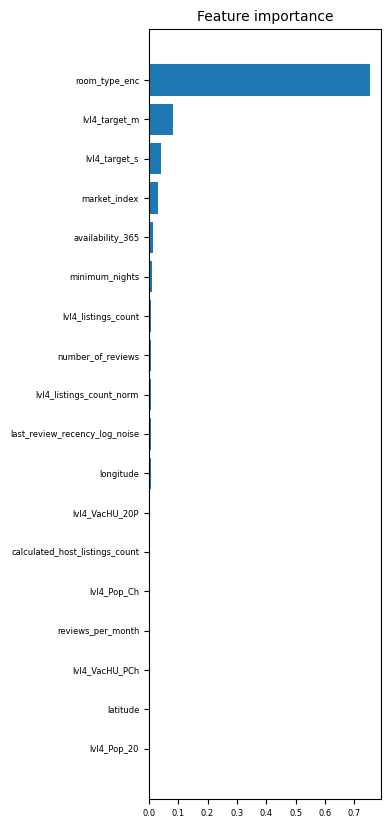

In [35]:
# look at feature importance of basic XGBoost
sorted_idx = clf.feature_importances_.argsort()

fig, ax = plt.subplots(figsize = (3, 10))
ax.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("Feature importance")

### 5. Hyperparameter Optimization

We then turn to hyperparameter optimization of multiple models. We will use the RayTune library and its TuneSearchCV API.

This will allow us to sample a search space for hyperparameters for each model, as well as to use non-random sampling thanks to optimization algorithms like Bayesian optimization ('bayesian') or Tree-of-Parzen optimization ('hyperopt'). 

In [15]:
# hyperparameter optimization library
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial
from ray.tune.sklearn import TuneSearchCV
import os

In [16]:
# search spaces
tree_params = {
                "max_depth": tune.randint(3, 50),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.5, 1)
            }

bagging_params = {
                "n_estimators": tune.randint(50, 500),
                "max_samples": tune.uniform(0.1, 1),
                "max_features": tune.uniform(0.5, 1)
            }

rdForest_params = {
                "n_estimators": tune.randint(50, 500),
                "max_depth": tune.randint(3, 10),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.5, 1),
                "bootstrap": tune.choice([True, False])
            }

exTree_params = {
                "n_estimators": tune.randint(50, 500),
                "max_depth": tune.randint(3, 10),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.5, 1),
                "bootstrap": tune.choice([True, False]),
            }

gradBoost_params = {
                "n_estimators": tune.randint(50, 500),
                "max_depth": tune.randint(3, 10),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "subsample": tune.uniform(0.6,1),
                "max_features": tune.uniform(0.5, 1),
                "learning_rate": tune.loguniform(1e-3, 1e-1)
            }

adaBoost_params = {
                "n_estimators": tune.randint(50, 500),
                "learning_rate": tune.loguniform(1e-3, 1e-1)   
            }

XGBoost_params = {
                "n_estimators": tune.randint(50, 500),
                "max_depth": tune.randint(3, 10),
                "min_child_weight": tune.uniform(1, 10),
                "colsample_bytree": tune.uniform(0.5, 1),
                "subsample": tune.uniform(0.6,1),
                "eta": tune.loguniform(1e-3, 1e-1)
            }

In [17]:
# loading models
tree_mdl = DecisionTreeRegressor()
bagging_mdl = BaggingRegressor()
rdForest_mdl = RandomForestRegressor()
exTree_mdl = ExtraTreesRegressor()
gradBoost_mdl = GradientBoostingRegressor()
adaBoost_mdl = AdaBoostRegressor()
XGBoost_mdl = XGBRegressor()

In [18]:
# tuning TreeRegressor with 5-fold cv
tune_search = TuneSearchCV(
    tree_mdl,
    tree_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/tree.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.6409087615694102}
The TuneSearchCV best score : 0.5187349269137311
R squared train: 0.6148423582057752
R squared test : 0.5161693338603761


['models/tree.joblib']

In [19]:
# tuning BaggingRegressor with 5-fold cv
tune_search = TuneSearchCV(
    bagging_mdl,
    bagging_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/treeBagging.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 484, 'max_samples': 0.514807886610813, 'max_features': 0.9960794665458674}
The TuneSearchCV best score : 0.5748262648084076
R squared train: 0.8492128089965474
R squared test : 0.5674734333384126


['models/treeBagging.joblib']

In [20]:
# tuning RandomForestRegressor with 5-fold cv
tune_search = TuneSearchCV(
    rdForest_mdl,
    rdForest_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/randomForest.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 463, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.6219456082507067, 'bootstrap': True}
The TuneSearchCV best score : 0.5747739631313463
R squared train: 0.6191474780331547
R squared test : 0.565107009004536


['models/randomForest.joblib']

In [21]:
# tuning ExtraTreeRegressor with 5-fold cv
tune_search = TuneSearchCV(
    exTree_mdl,
    exTree_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/extraTree.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 201, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7785063833445279, 'bootstrap': False}
The TuneSearchCV best score : 0.5477881692742861
R squared train: 0.5633036653285779
R squared test : 0.5407413178519189


['models/extraTree.joblib']

In [22]:
# tuning GradientBoostingRegressor with 5-fold cv
tune_search = TuneSearchCV(
    gradBoost_mdl,
    gradBoost_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/gradientBoosting.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 97, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.8489492449675523, 'max_features': 0.5528735132281442, 'learning_rate': 0.06567549114553016}
The TuneSearchCV best score : 0.5888823828842951
R squared train: 0.691336910304873
R squared test : 0.57743865659876


['models/gradientBoosting.joblib']

In [23]:
# tuning adaBoostRegressor with 5-fold cv
tune_search = TuneSearchCV(
    adaBoost_mdl,
    adaBoost_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/adaBoost.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 214, 'learning_rate': 0.00674487235649079}
The TuneSearchCV best score : 0.4884802452886164
R squared train: 0.4918726573821599
R squared test : 0.4873618249255163


['models/adaBoost.joblib']

In [24]:
# tuning XGBoostRegressor with 5-fold cv
tune_search = TuneSearchCV(
    XGBoost_mdl,
    XGBoost_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_train, y_train)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_pred = tune_search.predict(X_train)
r2_train = r2_score(y_train, y_pred)

# performance on test set
y_pred = tune_search.predict(X_test)
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

# save best model
filename = 'models/XGBoost.joblib'
dump(tune_search.best_estimator_, filename)

The TuneSearchCV best hyperparameters : {'n_estimators': 211, 'max_depth': 8, 'min_child_weight': 6.592534859322491, 'colsample_bytree': 0.9082380419733264, 'subsample': 0.8921979311968204, 'eta': 0.033866561301469346}
The TuneSearchCV best score : 0.5909914922974862
R squared train: 0.6967433534331737
R squared test : 0.5787039040911421


['models/XGBoost.joblib']

### 6. Model Evaluation

We compare all of our models by creating a metrics table. 

Ensemble methods provide the best results (higher R-Squared, lower errors), although AdaBoost underperforms all other models. XGBoost is the best performer.

In [29]:
# load best models
path = 'models/'
tree_mdl = load(path + 'tree.joblib')
treeBagging_mdl = load(path + 'treeBagging.joblib')
randomForest_mdl = load(path + 'randomForest.joblib')
extraTree_mdl = load(path + 'extraTree.joblib')
gradientBoosting_mdl = load(path + 'gradientBoosting.joblib')
adaBoost_mdl = load(path + 'adaBoost.joblib')
XGBoost_mdl = load(path + 'XGBoost.joblib')

# model predictions
y_tree = tree_mdl.predict(X_test)
y_treeBagging = treeBagging_mdl.predict(X_test)
y_randomForest = randomForest_mdl.predict(X_test)
y_extraTree = extraTree_mdl.predict(X_test)
y_gradientBoosting = gradientBoosting_mdl.predict(X_test)
y_adaBoost = adaBoost_mdl.predict(X_test)
y_XGBoost = XGBoost_mdl.predict(X_test)

y_list = [y_tree, y_treeBagging, y_randomForest, y_extraTree, y_gradientBoosting, y_adaBoost, y_XGBoost]
mdl_list = ['Decision Tree', 'Tree Bagging', 'Random Forest', 'ExtraTree', 'Gradient Boosting', 'AdaBoost', 'XGBoost']

# model evaluations
report = []
for i, y_pred in enumerate(y_list):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    metrics = pd.Series({'Model': mdl_list[i],
                         'MSE': mse,
                         'RMSE': rmse,
                         'MAE': mae,
                         'R-Squared': r2})
    
    report.append(metrics)

df_report = pd.DataFrame(report)
df_report

,Model,MSE,RMSE,MAE,R-Squared
0,Decision Tree,2827.738211,53.176482,36.560258,0.516169
1,Tree Bagging,2527.892475,50.278151,35.096359,0.567473
2,Random Forest,2541.722992,50.415503,35.152424,0.565107
3,ExtraTree,2684.127765,51.808568,36.484086,0.540741
4,Gradient Boosting,2469.650936,49.695583,34.214565,0.577439
5,AdaBoost,2996.103095,54.736670,39.765072,0.487362
6,XGBoost,2462.256223,49.621127,34.146985,0.578704


### 7. Ensemble Voting

Finally, we attempt to build an ensemble model aggregating the predictive power of all our best performing models so far.

We retain all those that have similar high performance (i.e. all of them except for Decision Tree and AdaBoost).

In [33]:
# create ensemble model
ensemble_mdl = VotingRegressor([('Tree Bagging', treeBagging_mdl), 
                                ('Random Forest', randomForest_mdl), 
                                ('ExtraTree', extraTree_mdl), 
                                ('Gradient Boosting', gradientBoosting_mdl),
                                ('XGBoost', XGBoost_mdl)])

# fit model
ensemble_mdl = ensemble_mdl.fit(X_train, y_train)

# predict
y_pred = ensemble_mdl.predict(X_test)

# evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

metrics = pd.Series({'Model': 'Ensemble Vote',
                     'MSE': mse,
                     'RMSE': rmse,
                     'MAE': mae,
                     'R-Squared': r2})

report.append(metrics)
df_report = pd.DataFrame(report)
df_report

,Model,MSE,RMSE,MAE,R-Squared
0,Decision Tree,2827.738211,53.176482,36.560258,0.516169
1,Tree Bagging,2527.892475,50.278151,35.096359,0.567473
2,Random Forest,2541.722992,50.415503,35.152424,0.565107
3,ExtraTree,2684.127765,51.808568,36.484086,0.540741
4,Gradient Boosting,2469.650936,49.695583,34.214565,0.577439
5,AdaBoost,2996.103095,54.736670,39.765072,0.487362
6,XGBoost,2462.256223,49.621127,34.146985,0.578704
7,Ensemble Vote,2477.203215,49.771510,34.570035,0.576146
